In [196]:
# Imports

from matplotlib import pyplot as plt
% matplotlib inline
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
import pandas as pd
import datetime
import numpy as np

In [224]:
# Initialize dataframe object, specify time axis and variable names
df1 = pd.read_csv('./data/daily_summaries_all.csv', sep=",")
df1['Date'] = pd.to_datetime(df1['Date'], format='%Y-%m-%d')

# select columns
df1 = df1[['SleepEfficiency','LowLatitude']]




# check for nans
print('nans found in:')

for column in df1:
    sequence = True
    indices_of_nans = df1.loc[pd.isna(df1[column]), :].index
    print(indices_of_nans)
    for i in indices_of_nans:
        if sequence:
            df1 = df1.drop([i], axis=0)
        else:
            sequence = False

print(df1)




nans found in:
Int64Index([  0,   1,   2, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865,
            866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878,
            879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891,
            892, 893, 894, 895, 896],
           dtype='int64')
Int64Index([855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867,
            868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880,
            881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893,
            894, 895, 896],
           dtype='int64')


KeyError: '[0] not found in axis'

effects are instantaneous here, but actually sleep and exercise are never contemporary. sleep of the night is written for the next day. then after wakeup exercise is tracked. sleepDay1 -> exerciseDay1 -> sleepDay2 -> exerciseDay2 ...

In [198]:
# insert blanc row after every row
df1.index = range(1, 2 * len(df1) + 1, 2)
df = df1.reindex(index=range(2 * len(df1)))

# modify df:
# 1. add morning date time
# 2. write heart points
# 3. write sleep eff
# 4. write evening date time
for i, row in df.iterrows():
    if i % 2 == 0:
        if i != 0:
            df.loc[i, 'Date'] = df.loc[i - 1, 'Date'] + datetime.timedelta(hours=7, minutes=0)
            df.loc[i, 'HeartPoints'] = df.loc[i - 1, 'HeartPoints']
        if i < len(df):
            df.loc[i, 'SleepEfficiency'] = df.loc[i + 1, 'SleepEfficiency']

    else:  # i % 2 == 1:
        # df.loc[i, 'SleepEfficiency'] = df.loc[i+1, 'SleepEfficiency']
        df.loc[i, 'Date'] = df.loc[i, 'Date'] + datetime.timedelta(hours=23, minutes=0)

    # df.loc[i, 'HeartPoints'] = 1.0#df.loc[i-1, 'HeartPoints']
    # df.loc[i, 'SleepEfficiency'] = 1.0#df.loc[i+1, 'SleepEfficiency']

df = df.iloc[1:]  # drop first row as it's missing data
df = df.drop(['Date'], axis=1)  # drop date col
#
# # standardize data
df -= df.mean(axis=0)
df /= df.std(axis=0)
print(df)


      SleepEfficiency  HeartPoints
1            0.203871     1.515463
2            0.203871     1.515463
3            0.203871     0.652997
4            0.203871     0.652997
5            0.203871    -0.041767
...               ...          ...
1699         0.651285    -1.143807
1700        -1.585782    -1.143807
1701        -1.585782     0.676955
1702         0.651285     0.676955
1703         0.651285    -0.209469

[1703 rows x 2 columns]


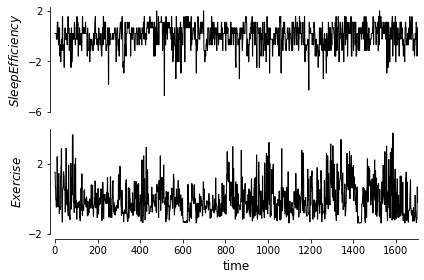

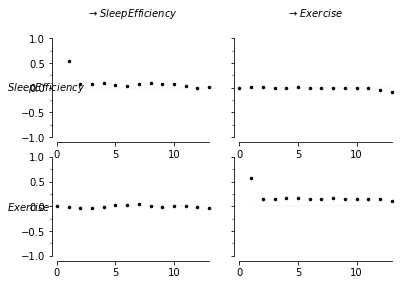


## Significant links at alpha = 0.05:

    Variable $SleepEfficiency$ has 7 link(s):
        ($SleepEfficiency$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.684
        ($SleepEfficiency$ -2): pval = 0.00000 | qval = 0.00000 | val = -0.511
        ($SleepEfficiency$ -3): pval = 0.00000 | qval = 0.00000 | val =  0.416
        ($SleepEfficiency$ -4): pval = 0.00000 | qval = 0.00000 | val = -0.354
        ($SleepEfficiency$ -5): pval = 0.00000 | qval = 0.00000 | val =  0.298
        ($SleepEfficiency$ -6): pval = 0.00000 | qval = 0.00000 | val = -0.251
        ($Exercise$ -7): pval = 0.01154 | qval = 0.03751 | val =  0.062

    Variable $Exercise$ has 9 link(s):
        ($Exercise$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.694
        ($Exercise$ -2): pval = 0.00000 | qval = 0.00000 | val = -0.504
        ($Exercise$ -3): pval = 0.00000 | qval = 0.00000 | val =  0.452
        ($Exercise$ -4): pval = 0.00000 | qval = 0.00000 | val = -0.335
        ($Exercise$ -5): pval = 0.00000 

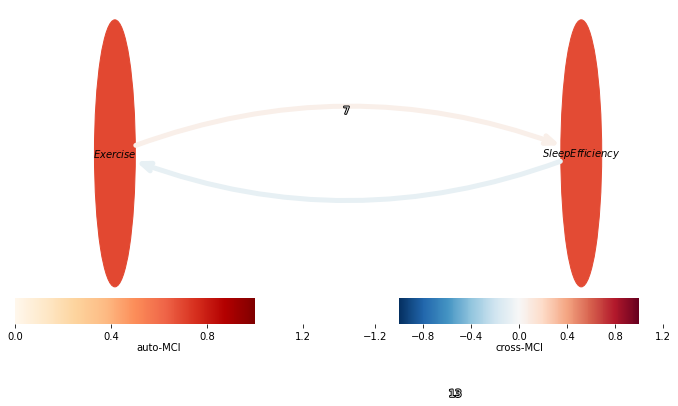

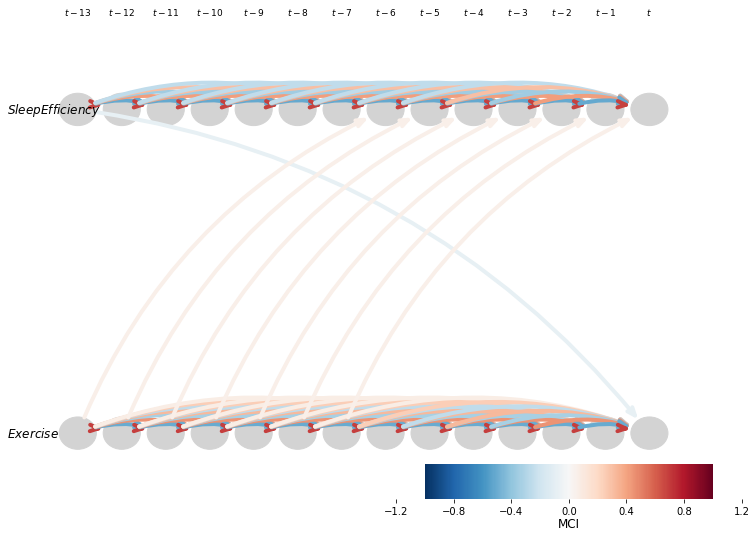

In [209]:
tau_max = 13
alpha_level = 0.05
verbosity = 0
var_names = [r'$SleepEfficiency$', r'$Exercise$']
dataframe = pp.DataFrame(df.values, datatime=np.arange(len(df)),
                         var_names=var_names)

tp.plot_timeseries(dataframe);
plt.show()

parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr,
    verbosity=verbosity)

correlations = pcmci.get_lagged_dependencies(tau_max=tau_max, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names': var_names,
                                                                        'x_base': 5, 'y_base': .5});
plt.show()

pcmci.verbosity = verbosity
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')
pcmci.print_significant_links(
    p_matrix=results['p_matrix'],
    q_matrix=q_matrix,
    val_matrix=results['val_matrix'],
    alpha_level=alpha_level)

link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                                             val_matrix=results['val_matrix'], alpha_level=alpha_level)['link_matrix']
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    figsize=(10, 6),
);
plt.show()

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(12, 8),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
);
plt.show()